# Import Library

In [25]:
from feature_engineering import apply_feature_engineering, add_dummies
from data_loading import load_data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Data Loading

In [2]:
# Call the load_data to get the data as a pandas dataframe
df = load_data()
df.head()

,searchDate,flightDate,startingAirport,destinationAirport,travelDuration,isBasicEconomy,isRefundable,isNonStop,totalFare,seatsRemaining,totalTravelDistance,segmentsDepartureTimeRaw,segmentsAirlineCode,segmentsCabinCode
0,2022-04-16,2022-04-17,ATL,BOS,PT2H29M,False,False,True,248.6,9,947.0,2022-04-17T12:57:00.000-04:00,DL,coach
1,2022-04-16,2022-04-17,ATL,BOS,PT2H30M,False,False,True,248.6,4,947.0,2022-04-17T06:30:00.000-04:00,DL,coach
2,2022-04-16,2022-04-17,ATL,BOS,PT2H30M,False,False,True,248.6,9,947.0,2022-04-17T11:35:00.000-04:00,DL,coach
3,2022-04-16,2022-04-17,ATL,BOS,PT2H32M,False,False,True,248.6,8,947.0,2022-04-17T13:59:00.000-04:00,DL,coach
4,2022-04-16,2022-04-17,ATL,BOS,PT2H34M,False,False,True,248.6,9,947.0,2022-04-17T09:59:00.000-04:00,DL,coach


In [3]:
# The data is too large to use in entirety, set a sample of 800,000 rows
sample_size = 800000

# Get the first 800,000 rows
df_sample = df.iloc[:sample_size]

# Feature Engineering

In [4]:
# Call the apply_feature_engineering function from feature_engineering to get the data ready for ML Modeling
df_sample = apply_feature_engineering(df_sample, rnn=True)

Starting feature engineering...
Converting date columns...
Date conversion done. Time elapsed: 0.13s
Extracting travel duration...
Travel duration extraction done. Time elapsed: 1.17s
Imputing missing travel distances...
Imputation done. Time elapsed: 1.18s
Processing departure times...
Departure time processing done. Time elapsed: 192.74s
Extracting departure hour and float...
Departure time extraction done. Time elapsed: 192.78s
Processing airline codes...
Airline code processing done. Time elapsed: 193.77s
Processing cabin codes...
Cabin class processing done. Time elapsed: 195.63s
Binning seatsRemaining...
Seats binning done. Time elapsed: 195.64s
Calculating days to departure...
Day of week processing done. Time elapsed: 195.67s
Processing holiday features...
Holiday features processing done. Time elapsed: 195.71s
Dropping columns...
Dropping columns done. Time elapsed: 195.78s
Renaming columns...
Renaming done. Total time elapsed: 195.78s
Adding dummies...
Dummies added. Total ti

In [5]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 52 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   flightDate                800000 non-null  datetime64[ns]
 1   startingAirport           800000 non-null  object        
 2   destinationAirport        800000 non-null  object        
 3   travelDuration            800000 non-null  int64         
 4   isRefundable              800000 non-null  bool          
 5   isNonStop                 800000 non-null  bool          
 6   totalFare                 800000 non-null  float64       
 7   seatsRemaining            800000 non-null  int64         
 8   airlineCode               800000 non-null  object        
 9   cabinClass                800000 non-null  object        
 10  travelDistance            800000 non-null  int64         
 11  departureTimeHour         800000 non-null  int32         
 12  de

In [6]:
# df_sample.to_csv('data/datasample.csv', index=False)

In [7]:
df_sample.head()

,flightDate,startingAirport,destinationAirport,travelDuration,isRefundable,isNonStop,totalFare,seatsRemaining,airlineCode,cabinClass,...,destinationAirport_LAX,destinationAirport_LGA,destinationAirport_MIA,destinationAirport_OAK,destinationAirport_ORD,destinationAirport_PHL,destinationAirport_SFO,cabinClass_basic economy,binnedSeatsRemaining_1,binnedSeatsRemaining_2
0,2022-04-17,ATL,BOS,149,False,True,248.6,9,,,...,False,False,False,False,False,False,False,False,False,True
1,2022-04-17,ATL,BOS,150,False,True,248.6,4,,,...,False,False,False,False,False,False,False,False,True,False
2,2022-04-17,ATL,BOS,150,False,True,248.6,9,,,...,False,False,False,False,False,False,False,False,False,True
3,2022-04-17,ATL,BOS,152,False,True,248.6,8,,,...,False,False,False,False,False,False,False,False,False,True
4,2022-04-17,ATL,BOS,154,False,True,248.6,9,,,...,False,False,False,False,False,False,False,False,False,True


Summary statistics for unique airlines per group:
count    14270.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: unique_airlines, dtype: float64
0.00% of groups have more than one airline.


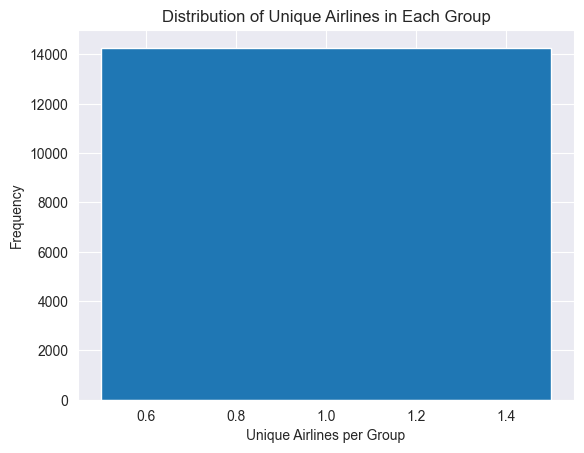

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

grouped = df_sample.groupby(['flightDate', 'startingAirport', 'destinationAirport'])

airline_variation = grouped['airlineCode'].nunique().reset_index(name='unique_airlines')

summary_stats = airline_variation['unique_airlines'].describe()
print("Summary statistics for unique airlines per group:")
print(summary_stats)

multi_airline_percentage = (airline_variation['unique_airlines'] > 1).mean() * 100
print(f"{multi_airline_percentage:.2f}% of groups have more than one airline.")

plt.hist(airline_variation['unique_airlines'], bins=range(1, airline_variation['unique_airlines'].max()+2), align='left')
plt.xlabel("Unique Airlines per Group")
plt.ylabel("Frequency")
plt.title("Distribution of Unique Airlines in Each Group")
plt.show()

# RNN

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
def create_sequences_by_group(df, sequence_length):
    X_seq_list = []
    y_seq_list = []

    groups = df.groupby(['flightDate', 'startingAirport', 'destinationAirport'])

    for group_keys, group_df in groups:
        # Sort the group by daysToDeparture
        group_df = group_df.sort_values("daysToDeparture")

        # Only build a sequence if the group is large enough.
        if len(group_df) <= sequence_length:
            continue

        # Drop columns that are used for grouping (keep flight date for reference)
        X_group = group_df.drop(columns=['totalFare', 'flightDate', 'startingAirport', 'destinationAirport'])

        # Dropping Bugged columns for now:
        X_group = X_group.drop(columns=['airlineCode', 'cabinClass'])

        y_group = group_df['totalFare']

        # Ensure the feature data is numeric (convert booleans to float, etc.)
        X_group = X_group.astype('float32')

        X_values = X_group.to_numpy()
        y_values = y_group.to_numpy().reshape(-1, 1)

        for i in range(len(X_values) - sequence_length):
            X_seq_list.append(X_values[i:i+sequence_length])
            y_seq_list.append(y_values[i + sequence_length])

    return np.array(X_seq_list), np.array(y_seq_list)


In [30]:
sequence_length = 60
df_sample = df_sample.fillna(0)
X_sequences, y_sequences = create_sequences_by_group(df_sample, sequence_length)

print("X_sequences shape:", X_sequences.shape)  # (num_sequences, sequence_length, num_features)
print("y_sequences shape:", y_sequences.shape)

X_sequences shape: (186386, 60, 46)
y_sequences shape: (186386, 1)


In [31]:
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_sequences, y_sequences, test_size=0.2, random_state=42
)

num_features = X_train_seq.shape[2]

In [32]:
scaler_X = MinMaxScaler()
X_train_seq_flat = X_train_seq.reshape(-1, num_features)
scaler_X.fit(X_train_seq_flat)
X_train_seq_scaled = scaler_X.transform(X_train_seq_flat).reshape(X_train_seq.shape)

X_test_seq_flat = X_test_seq.reshape(-1, num_features)
X_test_seq_scaled = scaler_X.transform(X_test_seq_flat).reshape(X_test_seq.shape)

scaler_y = MinMaxScaler()
scaler_y.fit(y_train_seq)
y_train_seq_scaled = scaler_y.transform(y_train_seq)
y_test_seq_scaled = scaler_y.transform(y_test_seq)

In [33]:
print("NaNs in X_train_seq_scaled:", np.isnan(X_train_seq_scaled).sum())
print("NaNs in y_train_seq_scaled:", np.isnan(y_train_seq_scaled).sum())

NaNs in X_train_seq_scaled: 0
NaNs in y_train_seq_scaled: 0


In [34]:
mps_devices = tf.config.list_physical_devices('MPS')
if mps_devices:
    print("Using MPS device")
    device_name = '/device:MPS:0'
else:
    print("MPS device not found, using CPU/GPU")
    device_name = '/device:CPU:0'

MPS device not found, using CPU/GPU


In [35]:
with tf.device(device_name):
    rnn_model = Sequential([
        SimpleRNN(50, activation='tanh', input_shape=(sequence_length, num_features)),
        Dense(1)  # Regression output for totalFare
    ])
    rnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    print("RNN model summary:")
    rnn_model.summary()

    history_rnn = rnn_model.fit(
        X_train_seq_scaled, y_train_seq_scaled,
        epochs=50, batch_size=32,
        validation_data=(X_test_seq_scaled, y_test_seq_scaled)
    )

    # Predict and reverse the scaling for evaluation
    y_pred_rnn = rnn_model.predict(X_test_seq_scaled)
    y_pred_rnn_original = scaler_y.inverse_transform(y_pred_rnn)
    y_test_rnn_original = scaler_y.inverse_transform(y_test_seq_scaled)

    mae_rnn = mean_absolute_error(y_test_rnn_original, y_pred_rnn_original)
    rmse_rnn = np.sqrt(mean_squared_error(y_test_rnn_original, y_pred_rnn_original))
    r2_rnn = r2_score(y_test_rnn_original, y_pred_rnn_original)
    print(f"RNN Model - MAE: {mae_rnn:.2f}, RMSE: {rmse_rnn:.2f}, R²: {r2_rnn:.4f}")

RNN model summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         4,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,901 (19.14 KB)

 Trainable params: 4,901 (19.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.0142 - mae: 0.0626 - val_loss: 0.0029 - val_mae: 0.0334
Epoch 2/50
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.0031 - mae: 0.0332 - val_loss: 0.0032 - val_mae: 0.0325
Epoch 3/50
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0030 - mae: 0.0311 - val_loss: 0.0025 - val_mae: 0.0271
Epoch 4/50
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0028 - mae: 0.0302 - val_loss: 0.0025 - val_mae: 0.0292
Epoch 5/50
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0026 - mae: 0.0292 - val_loss: 0.0024 - val_mae: 0.0262
Epoch 6/50
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.0028 - mae: 0.0294 - val_loss: 0.0027 - val_mae: 0.0325
Epoch 7/50
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.0027 - mae: 0.0289 - val_loss: 0.0024 - val_mae: 0.0273
Epoch 8/50
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0026 - mae: 0.0283 - val_loss: 0.0028 - val_mae: 0.0348
Epoch 9/50
4660/4660 ━━━━━━━━━━━

In [36]:
with tf.device(device_name):
    lstm_model = Sequential([
        LSTM(50, activation='tanh', input_shape=(sequence_length, num_features)),
        Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    print("LSTM model summary:")
    lstm_model.summary()

    history_lstm = lstm_model.fit(
        X_train_seq_scaled, y_train_seq_scaled,
        epochs=50, batch_size=32,
        validation_data=(X_test_seq_scaled, y_test_seq_scaled)
    )

    # Predict and reverse the scaling for evaluation
    y_pred_lstm = lstm_model.predict(X_test_seq_scaled)
    y_pred_lstm_original = scaler_y.inverse_transform(y_pred_lstm)
    y_test_lstm_original = scaler_y.inverse_transform(y_test_seq_scaled)

    mae_lstm = mean_absolute_error(y_test_lstm_original, y_pred_lstm_original)
    rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm_original, y_pred_lstm_original))
    r2_lstm = r2_score(y_test_lstm_original, y_pred_lstm_original)
    print(f"LSTM Model - MAE: {mae_lstm:.2f}, RMSE: {rmse_lstm:.2f}, R²: {r2_lstm:.4f}")

LSTM model summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        19,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,451 (75.98 KB)

 Trainable params: 19,451 (75.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 46s 10ms/step - loss: 0.0038 - mae: 0.0352 - val_loss: 0.0024 - val_mae: 0.0267
Epoch 2/50
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 45s 10ms/step - loss: 0.0027 - mae: 0.0279 - val_loss: 0.0023 - val_mae: 0.0256
Epoch 3/50
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 43s 9ms/step - loss: 0.0025 - mae: 0.0267 - val_loss: 0.0024 - val_mae: 0.0293
Epoch 4/50
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 45s 10ms/step - loss: 0.0025 - mae: 0.0263 - val_loss: 0.0022 - val_mae: 0.0259
Epoch 5/50
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 46s 10ms/step - loss: 0.0024 - mae: 0.0254 - val_loss: 0.0022 - val_mae: 0.0237
Epoch 6/50
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 44s 10ms/step - loss: 0.0024 - mae: 0.0250 - val_loss: 0.0021 - val_mae: 0.0251
Epoch 7/50
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 43s 9ms/step - loss: 0.0023 - mae: 0.0247 - val_loss: 0.0021 - val_mae: 0.0236
Epoch 8/50
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 44s 9ms/step - loss: 0.0023 - mae: 0.0246 - val_loss: 0.0021 - val_mae: 0.0233
Epoch 9/50
4660/4660 ━━━━━━